In [6]:
import pandas
import numpy as np
import math
import matplotlib.pyplot as plot
from scipy.integrate import simps

import import_ipynb
import Kalman_Filter
import Particle_Filter

print(dir(Kalman_Filter))
print(dir(Particle_Filter))

['__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'get_ipython', 'kalman', 'math', 'norm', 'np', 'predict', 'update']
['__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'estimate', 'generate_particles', 'get_ipython', 'math', 'neff', 'norm', 'np', 'particle_filter', 'plot', 'predict', 'random', 'resample', 'residual_resample', 'systematic_resample', 'update']


In [7]:
def data(file_name):
    rssi_data = pandas.read_csv(file_name).values.flatten()
    rssi_data = np.flip(rssi_data)
    return rssi_data

def distances(x0, rssi_data, n):
    n = 2.58
    e = (x0 - rssi_data)/(10*n)
    d = np.exp(math.log(10)*e)
    return d

Reading file RSSI-5m.csv ...


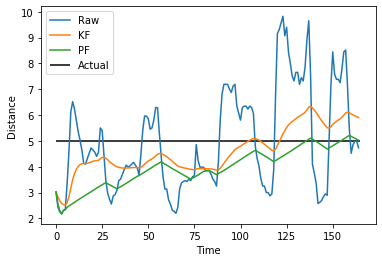

mean: 	Raw= 5.006118547450946 	KF= 4.599220586090477 	PF= 3.9670736543149596
rms: 	Raw= 5.367478993042648 	KF= 4.684290646114474 	PF= 4.036541647777199
STD: 	Raw= 1.9361321828898392 	KF= 0.8886781519521633 	PF= 0.7456507865482468

ERROR characteristics ---


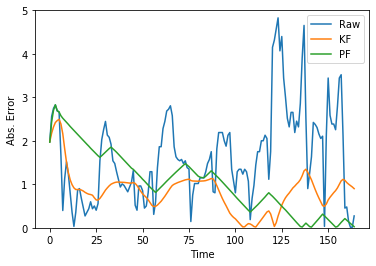

mean: 	Raw= 1.6481668104473832 	KF= 0.8508840183126146 	PF= 1.0498533520804623
rms: 	Raw= 1.9361418507549193 	KF= 0.9748707588038388 	PF= 1.273943456786945
STD: 	Raw= 1.0159682235111405 	KF= 0.4757829166236959 	PF= 0.7216230804344386
area: 	Raw= 272.28230790325193 	KF= 138.98229681467154 	PF= 172.33701550844995


In [21]:
x0 = -66.295
n = 2.58
actual_dist = 5
filename = 'RSSI-'+str(actual_dist)+'m.csv'
#filename = 'RSSI-1m-2m.csv'
print('Reading file',filename,'...')
raw_rssi = data(filename)
raw_dist = distances(x0, raw_rssi, n)
axis = np.arange(0, raw_dist.size, 1)

#kf_rssi = Kalman_Filter.kalman(raw_rssi)
#kf_dist = distances(x0, kf_rssi, n)
kf_dist = Kalman_Filter.kalman(raw_dist)

pf_dist = Particle_Filter.particle_filter(raw_dist, 1000)

plot.ylabel('Distance')
plot.xlabel('Time')
if actual_dist == 1:
    plot.ylim(0., 3.)
plot.plot(axis, raw_dist, label='Raw')
plot.plot(axis, kf_dist, label='KF')
plot.plot(axis, pf_dist, label='PF')
plot.hlines([actual_dist], 0, len(raw_rssi), label='Actual')
plot.legend()
plot.savefig('dist-time-'+str(actual_dist)+'m.png')
plot.pause(0.01)

print('mean:','\tRaw=',np.mean(raw_dist),'\tKF=',np.mean(kf_dist),'\tPF=',np.mean(pf_dist))
print('rms:','\tRaw=',np.sqrt(np.mean(raw_dist**2)),'\tKF=',np.sqrt(np.mean(kf_dist**2)),'\tPF=',np.sqrt(np.mean(pf_dist**2)))
print('STD:','\tRaw=',np.std(raw_dist),'\tKF=',np.std(kf_dist),'\tPF=',np.std(pf_dist))

print('\nERROR characteristics ---')

raw_error = np.abs(actual_dist - raw_dist)
kf_error = np.abs(actual_dist - kf_dist)
pf_error = np.abs(actual_dist - pf_dist)

plot.ylabel('Abs. Error')
plot.xlabel('Time')
plot.ylim(0., 5.)
plot.plot(axis, raw_error, label='Raw')
plot.plot(axis, kf_error, label='KF')
plot.plot(axis, pf_error, label='PF')
plot.legend()
plot.savefig('error-time-'+str(actual_dist)+'m.png')
plot.pause(0.01)

print('mean:','\tRaw=',np.mean(raw_error),'\tKF=',np.mean(kf_error),'\tPF=',np.mean(pf_error))
print('rms:','\tRaw=',np.sqrt(np.mean(raw_error**2)),'\tKF=',np.sqrt(np.mean(kf_error**2)),'\tPF=',np.sqrt(np.mean(pf_error**2)))
print('STD:','\tRaw=',np.std(raw_error),'\tKF=',np.std(kf_error),'\tPF=',np.std(pf_error))

print('area:','\tRaw=',simps(raw_error, dx=1),'\tKF=',simps(kf_error, dx=1),'\tPF=',simps(pf_error, dx=1))

Efficiency Comparison ---
Testing Kalman Filter ...
time:  0.060002099999962866
Mean Error ---
rel err: [ 2.19720998 60.6556114   2.75028049  8.01558828]
rms err: [0.14726962 1.25901242 0.62926923 0.97487076]


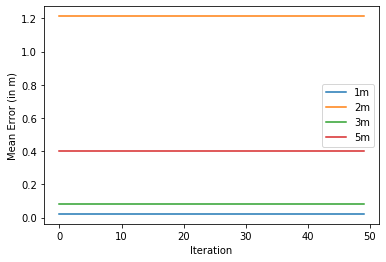

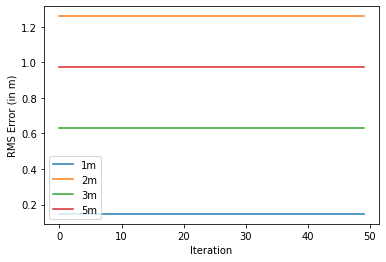

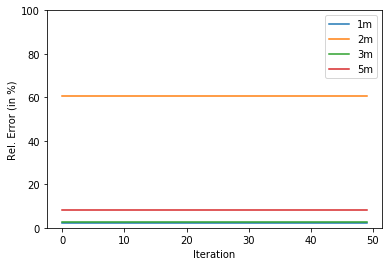

In [4]:
print('Efficiency Comparison ---')

from timeit import timeit

number = 50

# Kalman Filter
print("Testing Kalman Filter ...")
kf_mean_error = []
kf_rms_error = []
kf_rel_error = []

kf_setup = '''
from __main__ import Kalman_Filter, data, np, kf_mean_error, kf_rms_error, kf_rel_error, distances
rssi_data = [data('RSSI-1m.csv'),data('RSSI-2m.csv'),data('RSSI-3m.csv'),data('RSSI-5m.csv')]
dist_data = [distances(-66.295, rssi_data[0], 2.58), distances(-66.295, rssi_data[1], 2.58), distances(-66.295, rssi_data[2], 2.58), distances(-66.295, rssi_data[3], 2.58)]
actual_dist = [1,2,3,5]
'''
kf_stmt = '''
mean_error = []
rms_error = []
for i in range(len(dist_data)):
    filtered_data = Kalman_Filter.kalman(dist_data[i])
    mean_error.append(np.mean(np.abs(actual_dist[i] - np.mean(filtered_data))))
    rms_error.append(np.sqrt(np.mean((filtered_data - actual_dist[i])**2)))
kf_mean_error.append(mean_error)
kf_rms_error.append(rms_error)
kf_rel_error.append(np.divide(mean_error, actual_dist))
'''

kf_time = timeit(setup=kf_setup, stmt=kf_stmt, number=number)
print('time: ',kf_time)

kf_mean_error = np.array(kf_mean_error)
kf_rms_error = np.array(kf_rms_error)
kf_rel_error = np.array(kf_rel_error)
#print('\nAbs. Error\n',kf_error_array)
#print('\nRel. Error\n',kf_rel_error)
print('Mean Error ---')
print('rel err:',np.mean(kf_rel_error, axis=0) * 100.)
print('rms err:',np.mean(kf_rms_error, axis=0))

plot.ylabel('Mean Error (in m)')
plot.xlabel('Iteration')
lines = plot.plot(kf_mean_error)
lines[0].set_label('1m')
lines[1].set_label('2m')
lines[2].set_label('3m')
lines[3].set_label('5m')
plot.legend()
plot.pause(0.01)

plot.ylabel('RMS Error (in m)')
plot.xlabel('Iteration')
lines = plot.plot(kf_rms_error)
lines[0].set_label('1m')
lines[1].set_label('2m')
lines[2].set_label('3m')
lines[3].set_label('5m')
plot.legend()
#plot.savefig('rms-error-kalman-'+str(number)+'-iters.png')
plot.pause(0.01)

plot.ylabel('Rel. Error (in %)')
plot.xlabel('Iteration')
lines = plot.plot(kf_rel_error * 100.)
lines[0].set_label('1m')
lines[1].set_label('2m')
lines[2].set_label('3m')
lines[3].set_label('5m')
plot.legend()
plot.ylim(0., 100.)
#plot.savefig('rel-error-kalman-'+str(number)+'-iters.png')
plot.pause(0.01)

Efficiency Comparison ---
Testing Particle Filter ...
time:  42.935906399999965
Mean Error ---
rel err: [ 1.66404895 61.65498857  6.53959066 20.44525287]
rel err: [0.14694755 1.27633601 0.67849807 1.26807196]


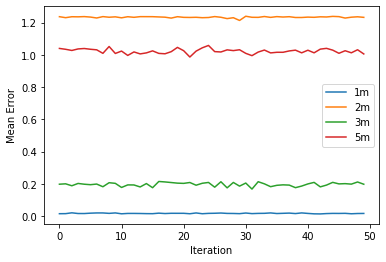

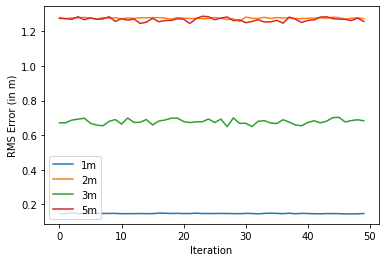

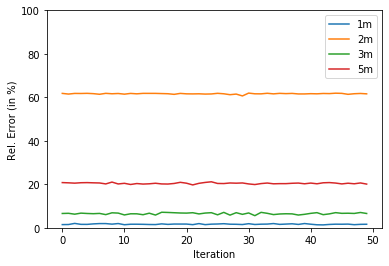

In [5]:
print('Efficiency Comparison ---')

from timeit import timeit

number = 50

# Particle Filter
print("Testing Particle Filter ...")
pf_mean_error = []
pf_rms_error = []
pf_rel_error = []

pf_setup = '''
from __main__ import Particle_Filter, data, np, pf_mean_error, pf_rms_error, pf_rel_error, distances
rssi_data = [data('RSSI-1m.csv'),data('RSSI-2m.csv'),data('RSSI-3m.csv'),data('RSSI-5m.csv')]
dist_data = [distances(-66.295, rssi_data[0], 2.58), distances(-66.295, rssi_data[1], 2.58), distances(-66.295, rssi_data[2], 2.58), distances(-66.295, rssi_data[3], 2.58)]
actual_dist = [1,2,3,5]
'''
pf_stmt = '''
mean_error = []
rms_error = []
for i in range(len(dist_data)):
    filtered_data = Particle_Filter.particle_filter(dist_data[i], enable_neffing=True)
    mean_error.append(np.mean(np.abs(actual_dist[i] - np.mean(filtered_data))))
    rms_error.append(np.sqrt(np.mean((filtered_data - actual_dist[i])**2)))
pf_mean_error.append(mean_error)
pf_rms_error.append(rms_error)
pf_rel_error.append(np.divide(mean_error, actual_dist))
'''

pf_time = timeit(setup=pf_setup, stmt=pf_stmt, number=number)
print('time: ',pf_time)

pf_mean_error = np.array(pf_mean_error)
pf_rms_error = np.array(pf_rms_error)
pf_rel_error = np.array(pf_rel_error)
#print('\nAbs. Error\n',kf_error_array)
#print('\nRel. Error\n',kf_rel_error)
print('Mean Error ---')
print('rel err:',np.mean(pf_rel_error, axis=0) * 100.)
print('rms err:',np.mean(pf_rms_error, axis=0))

#print('rel_err mean: ',np.mean(pf_rel_error),'\tSTD: ','{:.6f}'.format(np.mean(np.std(pf_rel_error,axis=0))))

plot.ylabel('Mean Error')
plot.xlabel('Iteration')
lines = plot.plot(pf_mean_error)
lines[0].set_label('1m')
lines[1].set_label('2m')
lines[2].set_label('3m')
lines[3].set_label('5m')
plot.legend()
plot.pause(0.01)

plot.ylabel('RMS Error (in m)')
plot.xlabel('Iteration')
lines = plot.plot(pf_rms_error)
lines[0].set_label('1m')
lines[1].set_label('2m')
lines[2].set_label('3m')
lines[3].set_label('5m')
plot.legend()
#plot.savefig('rms-error-particle-'+str(number)+'-iters.png')
plot.pause(0.01)

plot.ylabel('Rel. Error (in %)')
plot.xlabel('Iteration')
lines = plot.plot(pf_rel_error * 100.)
lines[0].set_label('1m')
lines[1].set_label('2m')
lines[2].set_label('3m')
lines[3].set_label('5m')
plot.legend()
plot.ylim(0., 100.)
#plot.savefig('rel-error-particle-'+str(number)+'-iters.png')
plot.pause(0.01)

In [4]:
print('Error in Raw values ---')

rssi_data = [data('RSSI-1m.csv'),data('RSSI-2m.csv'),data('RSSI-3m.csv'),data('RSSI-5m.csv')]
dist_data = [distances(-66.295, rssi_data[0], 2.58), distances(-66.295, rssi_data[1], 2.58), distances(-66.295, rssi_data[2], 2.58), distances(-66.295, rssi_data[3], 2.58)]
actual_dist = [1,2,3,5]

std = []
mean_error = []
rms_error = []
for i in range(len(dist_data)):
    raw_data = dist_data[i]
    mean_error.append(np.mean(np.abs(actual_dist[i] - np.mean(raw_data))))
    rms_error.append(np.sqrt(np.mean((raw_data - actual_dist[i])**2)))
    std.append(np.std(actual_dist[i] - raw_data))
rel_error = np.divide(mean_error, actual_dist)

print('STD:',std)
print('mean err:',mean_error)
print('rel err:',rel_error * 100.)
print('rms err:',rms_error)

Error in Raw values ---
STD: [0.1745938388850707, 0.640819942748368, 0.7547027110719461, 1.9361321828898392]
mean err: [0.01556650221202549, 1.1209263255435586, 0.12463498258096317, 0.006118547450945755]
rel err: [ 1.55665022 56.04631628  4.15449942  0.12237095]
rms err: [0.17528640725322378, 1.2911723457078084, 0.7649248727700665, 1.9361418507549193]
